In [1]:
import ast 
import time 
import random 
import pandas as pd 
from tqdm import tqdm 
import matplotlib.pyplot as plt 

import requests 
import json 

In [2]:
test_df = pd.read_csv('/kaggle/input/fpt-ai-residency-batch-6-entry-test/b6_test_data.csv')
test_df.head(5)

,task_id,question,choices
0,k10171,Question: What will be output of the following...,"['10', '9', '8', 'Error']"
1,k10182,Question: Consider line 3. Identify the compil...,"['No compilation error', 'Only a lexical error..."
2,k10184,Question: Assume the conflicts part (a) of thi...,['Equal precedence and left associativity; exp...
3,k10206,Question: What will be output if you will exec...,"['2.00000', '4.00000', '6.00000', 'Compilation..."
4,k10215,Question: Select the output for code :\nstatic...,"['amish', 'ANKIT', 'harsh', 'Compile time error']"


In [3]:
def create_full_question(row):
    question = row['question']
    choices_str = row['choices']
    choices = ast.literal_eval(choices_str)
    
    formatted_choices = '\n'.join([f"{chr(65+i)}. {choice}" for i, choice in enumerate(choices)])
    full_question = f"{question}\n{formatted_choices}"
    return full_question

test_df['full_question'] = test_df.apply(create_full_question, axis=1)
test_df.head(5)

,task_id,question,choices,full_question
0,k10171,Question: What will be output of the following...,"['10', '9', '8', 'Error']",Question: What will be output of the following...
1,k10182,Question: Consider line 3. Identify the compil...,"['No compilation error', 'Only a lexical error...",Question: Consider line 3. Identify the compil...
2,k10184,Question: Assume the conflicts part (a) of thi...,['Equal precedence and left associativity; exp...,Question: Assume the conflicts part (a) of thi...
3,k10206,Question: What will be output if you will exec...,"['2.00000', '4.00000', '6.00000', 'Compilation...",Question: What will be output if you will exec...
4,k10215,Question: Select the output for code :\nstatic...,"['amish', 'ANKIT', 'harsh', 'Compile time error']",Question: Select the output for code :\nstatic...


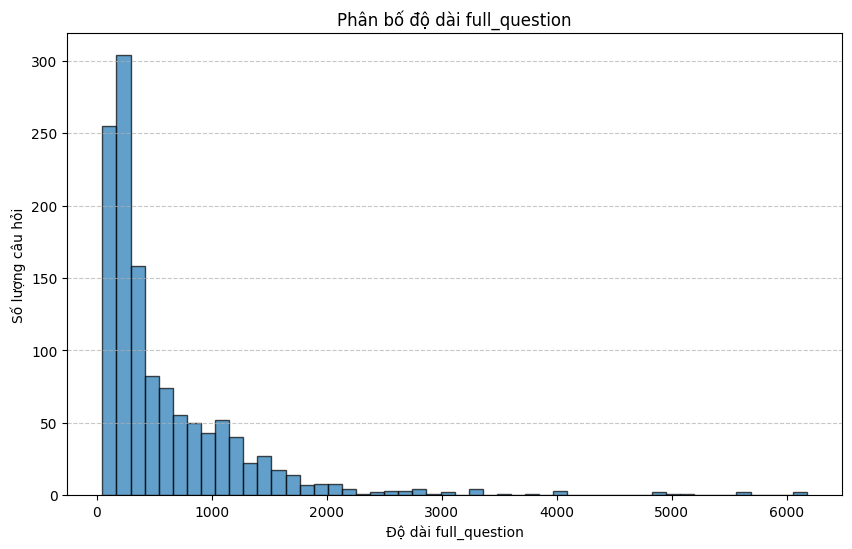

In [4]:
test_df["question_length"] = test_df["full_question"].apply(len)

plt.figure(figsize=(10, 6))
plt.hist(test_df["question_length"], bins=50, edgecolor="black", alpha=0.7)
plt.xlabel("Độ dài full_question")
plt.ylabel("Số lượng câu hỏi")
plt.title("Phân bố độ dài full_question")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [5]:
print(len(test_df))

1253


In [6]:
print(test_df.iloc[0]['full_question'])

Question: What will be output of the following c code?
#include<stdio.h>
int main()
{
    int a= sizeof(signed) +sizeof(unsigned);
    int b=sizeof(const)+sizeof(volatile);
    printf("%d",a+++b);
    return 0;
}
A. 10
B. 9
C. 8
D. Error


In [7]:
print(test_df.iloc[1]['full_question'])

Question: Consider line 3. Identify the compiler’s response about this line while creating the object-module
Int main()
{ int 1,N;
Fro (I,1 N,1);
}
A. No compilation error
B. Only a lexical error
C. Only syntactic errors
D. Both lexical and syntactic errors


In [ ]:
with open("/kaggle/input/apikey/api_key/llama.txt", "r") as f:
    LLAMA_API_KEY = ''

In [9]:
URL = "https://api.together.xyz/v1/models"

In [10]:
headers = {
    "Authorization": f"Bearer {LLAMA_API_KEY}",
    "Content-Type": "application/json"
}

response = requests.get(URL, headers=headers)
models = response.json()

print(json.dumps(models, indent=2))

[
  {
    "id": "WhereIsAI/UAE-Large-V1",
    "object": "model",
    "created": 1703216381,
    "type": "embedding",
    "running": false,
    "display_name": "UAE-Large-V1",
    "organization": "WhereIsAI",
    "link": "https://huggingface.co/bert-base-uncased",
    "license": "apache-2.0",
    "config": {
      "chat_template": null,
      "stop": [],
      "bos_token": null,
      "eos_token": null
    },
    "pricing": {
      "hourly": 0,
      "input": 0.016,
      "output": 0.016,
      "base": 0,
      "finetune": 0
    }
  },
  {
    "id": "meta-llama/Meta-Llama-3-70B-Instruct-Turbo",
    "object": "model",
    "created": 0,
    "type": "chat",
    "running": false,
    "display_name": "Meta Llama 3 70B Instruct Turbo",
    "organization": "Meta",
    "link": "https://huggingface.co/meta-llama/Meta-Llama-3-70B-Instruct",
    "license": "Llama-3 (Other)",
    "context_length": 8192,
    "config": {
      "chat_template": "{% set loop_messages = messages %}{% for message in loop

In [11]:
def ask_together_ai(questions):
    retry_delay = 60  

    prompt = "\n\n".join([q for i, q in enumerate(questions)])
    prompt += (
        "\n\nRespond with only the correct answer as a single letter: A, B, C, or D."
        " Do not provide any explanation, reasoning, or additional text."
        " Only return one letter per line corresponding to each question."
    )

    headers = {
        "Authorization": f"Bearer {LLAMA_API_KEY}",
        "Content-Type": "application/json"
    }
    data = {
        "model": "meta-llama/Llama-3-70b-chat-hf",
        "messages": [{"role": "user", "content": prompt}],
        "temperature": 0.7
    }

    while True:
        try:
            response = requests.post("https://api.together.xyz/v1/chat/completions", headers=headers, json=data)
            
            if response.status_code == 200:
                answers = response.json()["choices"][0]["message"]["content"].strip().split("\n")
                valid_choices = ["A", "B", "C", "D"]
                corrected_answers = [ans if ans in valid_choices else random.choice(valid_choices) for ans in answers]

                while len(corrected_answers) < len(questions):
                    corrected_answers.append(random.choice(valid_choices))

                return corrected_answers

            elif response.status_code == 429:  
                print(f"Quota exceeded. Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
            else:
                return f"Lỗi {response.status_code}: {response.text}"

        except requests.RequestException as e:
            print(f"Lỗi mạng: {e}. Đang thử lại sau {retry_delay} giây...")
            time.sleep(retry_delay)

In [12]:
question = """
Question: Consider line 3. Identify the compiler’s response about this line while creating the object-module
Int main()
{ int 1,N;
Fro (I,1 N,1);
}
A. No compilation error
B. Only a lexical error
C. Only syntactic errors
D. Both lexical and syntactic errors
Please only provide the correct answer as one of the options: A, B, C, or D.
"""
result = ask_together_ai([question])
print(json.dumps(result, indent=2))

[
  "D"
]


In [13]:
def generate_answers(df, num_samples, batch_size, is_test=False):
    correct_count = 0
    llama_answers = []
    
    for i in tqdm(range(0, num_samples, batch_size), desc="Processing Batches"):
        batch_df = df.iloc[i:i+batch_size]
        batch_questions = batch_df["full_question"].tolist()
        batch_answers = ask_together_ai(batch_questions)
        
        if len(batch_answers) != len(batch_df):
            batch_answers = batch_answers[:len(batch_df)]  
        
        llama_answers.extend(batch_answers)

        if not is_test:
            correct_count += sum(1 for pred, true in zip(batch_answers, batch_df["answer"]) if pred == true)

    if is_test:
        return llama_answers, None
    else:
        accuracy = correct_count / num_samples * 100
        return llama_answers, accuracy

In [14]:
num_samples = len(test_df)
test_df_subset = test_df.head(num_samples).copy()
llama_answers, accuracy = generate_answers(test_df_subset, num_samples, 1, True)
test_df_subset["llama_answers"] = llama_answers

Processing Batches:   0%|          | 1/1253 [00:00<11:42,  1.78it/s]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   0%|          | 3/1253 [01:02<6:54:06, 19.88s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   0%|          | 5/1253 [02:03<8:03:29, 23.24s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   1%|          | 7/1253 [03:04<8:27:53, 24.46s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   1%|          | 9/1253 [04:06<8:37:12, 24.95s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   1%|          | 11/1253 [05:07<8:40:47, 25.16s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   1%|          | 13/1253 [06:09<8:43:40, 25.34s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   1%|          | 15/1253 [07:11<8:45:47, 25.48s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   1%|▏         | 17/1253 [08:12<8:42:49, 25.38s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   2%|▏         | 19/1253 [09:13<8:42:26, 25.40s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   2%|▏         | 21/1253 [10:15<8:40:27, 25.35s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   2%|▏         | 23/1253 [11:16<8:38:40, 25.30s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   2%|▏         | 25/1253 [12:17<8:39:16, 25.37s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   2%|▏         | 27/1253 [13:19<8:38:07, 25.36s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   2%|▏         | 29/1253 [14:20<8:36:38, 25.33s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   2%|▏         | 31/1253 [15:22<8:38:39, 25.47s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   3%|▎         | 33/1253 [16:23<8:36:30, 25.40s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   3%|▎         | 35/1253 [17:24<8:33:52, 25.31s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   3%|▎         | 37/1253 [18:26<8:33:23, 25.33s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   3%|▎         | 39/1253 [19:27<8:31:39, 25.29s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   3%|▎         | 41/1253 [20:29<8:34:49, 25.49s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   3%|▎         | 43/1253 [21:30<8:31:07, 25.35s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   4%|▎         | 45/1253 [22:31<8:30:56, 25.38s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   4%|▍         | 47/1253 [23:32<8:28:25, 25.29s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   4%|▍         | 49/1253 [24:33<8:27:25, 25.29s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   4%|▍         | 51/1253 [25:35<8:28:32, 25.39s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   4%|▍         | 53/1253 [26:36<8:26:29, 25.32s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   4%|▍         | 55/1253 [27:37<8:26:22, 25.36s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   5%|▍         | 57/1253 [28:39<8:27:37, 25.47s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   5%|▍         | 59/1253 [29:40<8:23:53, 25.32s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   5%|▍         | 61/1253 [30:41<8:22:24, 25.29s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   5%|▌         | 63/1253 [31:43<8:22:01, 25.31s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   5%|▌         | 65/1253 [32:44<8:20:46, 25.29s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   5%|▌         | 67/1253 [33:45<8:19:58, 25.29s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   6%|▌         | 69/1253 [34:47<8:19:41, 25.32s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   6%|▌         | 71/1253 [35:48<8:19:02, 25.33s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   6%|▌         | 73/1253 [36:49<8:18:30, 25.35s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   6%|▌         | 75/1253 [37:50<8:17:03, 25.32s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   6%|▌         | 77/1253 [38:52<8:18:25, 25.43s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   6%|▋         | 79/1253 [39:54<8:18:10, 25.46s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   6%|▋         | 81/1253 [40:56<8:19:09, 25.55s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   7%|▋         | 83/1253 [41:57<8:15:24, 25.41s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   7%|▋         | 85/1253 [42:58<8:12:56, 25.32s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   7%|▋         | 87/1253 [43:59<8:12:07, 25.32s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   7%|▋         | 89/1253 [45:00<8:10:49, 25.30s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   7%|▋         | 91/1253 [46:02<8:09:45, 25.29s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   7%|▋         | 93/1253 [47:03<8:09:36, 25.32s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   8%|▊         | 95/1253 [48:04<8:07:15, 25.25s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   8%|▊         | 97/1253 [49:06<8:10:59, 25.48s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   8%|▊         | 99/1253 [50:07<8:09:08, 25.43s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   8%|▊         | 101/1253 [51:08<8:06:36, 25.34s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   8%|▊         | 103/1253 [52:10<8:06:37, 25.39s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   8%|▊         | 105/1253 [53:11<8:04:50, 25.34s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   9%|▊         | 107/1253 [54:12<8:03:47, 25.33s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   9%|▊         | 109/1253 [55:13<8:01:12, 25.24s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   9%|▉         | 111/1253 [56:14<8:00:32, 25.25s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   9%|▉         | 113/1253 [57:16<8:01:44, 25.36s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   9%|▉         | 115/1253 [58:17<7:59:57, 25.31s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   9%|▉         | 117/1253 [59:19<8:00:57, 25.40s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:   9%|▉         | 119/1253 [1:00:20<7:59:19, 25.36s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  10%|▉         | 121/1253 [1:01:22<7:59:35, 25.42s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  10%|▉         | 123/1253 [1:02:23<7:56:48, 25.32s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  10%|▉         | 125/1253 [1:03:24<7:58:06, 25.43s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  10%|█         | 127/1253 [1:04:25<7:55:13, 25.32s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  10%|█         | 129/1253 [1:05:27<7:57:09, 25.47s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  10%|█         | 131/1253 [1:06:29<7:54:54, 25.40s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  11%|█         | 133/1253 [1:07:30<7:54:17, 25.41s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  11%|█         | 135/1253 [1:08:32<7:53:16, 25.40s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  11%|█         | 137/1253 [1:09:33<7:51:29, 25.35s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  11%|█         | 139/1253 [1:10:34<7:50:06, 25.32s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  11%|█▏        | 141/1253 [1:11:35<7:49:35, 25.34s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  11%|█▏        | 143/1253 [1:12:37<7:48:14, 25.31s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  12%|█▏        | 145/1253 [1:13:38<7:47:25, 25.31s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  12%|█▏        | 147/1253 [1:14:39<7:46:46, 25.32s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  12%|█▏        | 149/1253 [1:15:40<7:45:44, 25.31s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  12%|█▏        | 151/1253 [1:16:41<7:44:18, 25.28s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  12%|█▏        | 153/1253 [1:17:43<7:45:13, 25.38s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  12%|█▏        | 155/1253 [1:18:45<7:45:39, 25.45s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  13%|█▎        | 157/1253 [1:19:46<7:43:57, 25.40s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  13%|█▎        | 159/1253 [1:20:48<7:44:17, 25.46s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  13%|█▎        | 161/1253 [1:21:49<7:41:29, 25.36s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  13%|█▎        | 163/1253 [1:22:50<7:41:13, 25.39s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  13%|█▎        | 165/1253 [1:23:53<7:43:32, 25.56s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  13%|█▎        | 167/1253 [1:24:54<7:39:29, 25.39s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  13%|█▎        | 169/1253 [1:25:56<7:39:59, 25.46s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  14%|█▎        | 171/1253 [1:26:57<7:38:11, 25.41s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  14%|█▍        | 175/1253 [1:28:00<3:50:00, 12.80s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  14%|█▍        | 177/1253 [1:29:02<5:44:37, 19.22s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  14%|█▍        | 179/1253 [1:30:03<6:38:37, 22.27s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  14%|█▍        | 181/1253 [1:31:05<7:08:11, 23.97s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  15%|█▍        | 183/1253 [1:32:06<7:19:20, 24.64s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  15%|█▍        | 185/1253 [1:33:07<7:25:26, 25.02s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  15%|█▍        | 187/1253 [1:34:08<7:26:08, 25.11s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  15%|█▌        | 189/1253 [1:35:10<7:27:48, 25.25s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  15%|█▌        | 191/1253 [1:36:11<7:27:09, 25.26s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  15%|█▌        | 193/1253 [1:37:12<7:26:19, 25.26s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  16%|█▌        | 195/1253 [1:38:13<7:26:14, 25.31s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  16%|█▌        | 197/1253 [1:39:14<7:24:34, 25.26s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  16%|█▌        | 199/1253 [1:40:16<7:24:18, 25.29s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  16%|█▌        | 201/1253 [1:41:17<7:24:16, 25.34s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  16%|█▌        | 203/1253 [1:42:19<7:24:19, 25.39s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  16%|█▋        | 205/1253 [1:43:20<7:23:36, 25.40s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  17%|█▋        | 207/1253 [1:44:21<7:22:26, 25.38s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  17%|█▋        | 209/1253 [1:45:23<7:21:45, 25.39s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  17%|█▋        | 211/1253 [1:46:24<7:21:15, 25.41s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  17%|█▋        | 213/1253 [1:47:26<7:20:40, 25.42s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  17%|█▋        | 215/1253 [1:48:27<7:18:19, 25.34s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  17%|█▋        | 217/1253 [1:49:28<7:17:32, 25.34s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  17%|█▋        | 219/1253 [1:50:30<7:16:22, 25.32s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  18%|█▊        | 221/1253 [1:51:31<7:14:09, 25.24s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  18%|█▊        | 223/1253 [1:52:32<7:14:29, 25.31s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  18%|█▊        | 225/1253 [1:53:34<7:16:08, 25.46s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  18%|█▊        | 227/1253 [1:54:35<7:15:37, 25.48s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  18%|█▊        | 229/1253 [1:55:37<7:14:19, 25.45s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  18%|█▊        | 231/1253 [1:56:39<7:14:15, 25.49s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  19%|█▊        | 233/1253 [1:57:40<7:12:23, 25.43s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  19%|█▉        | 235/1253 [1:58:41<7:10:32, 25.38s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  19%|█▉        | 237/1253 [1:59:43<7:09:32, 25.37s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  19%|█▉        | 239/1253 [2:00:44<7:10:22, 25.47s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  19%|█▉        | 241/1253 [2:01:46<7:08:45, 25.42s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  19%|█▉        | 243/1253 [2:02:47<7:06:45, 25.35s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  20%|█▉        | 245/1253 [2:03:48<7:05:32, 25.33s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  20%|█▉        | 247/1253 [2:04:49<7:04:20, 25.31s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  20%|█▉        | 249/1253 [2:05:51<7:02:48, 25.27s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  20%|██        | 251/1253 [2:06:52<7:02:25, 25.29s/it] 

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  20%|██        | 253/1253 [2:07:53<7:01:55, 25.32s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  20%|██        | 255/1253 [2:08:54<7:00:03, 25.25s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  21%|██        | 257/1253 [2:09:55<6:59:43, 25.28s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  21%|██        | 259/1253 [2:10:56<6:58:04, 25.24s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  21%|██        | 261/1253 [2:11:58<6:57:36, 25.26s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  21%|██        | 263/1253 [2:12:59<6:58:23, 25.36s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  21%|██        | 265/1253 [2:14:00<6:56:36, 25.30s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  21%|██▏       | 267/1253 [2:15:01<6:55:43, 25.30s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  21%|██▏       | 269/1253 [2:16:03<6:55:05, 25.31s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  22%|██▏       | 271/1253 [2:17:05<6:57:39, 25.52s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  22%|██▏       | 273/1253 [2:18:06<6:54:40, 25.39s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  22%|██▏       | 275/1253 [2:19:07<6:54:21, 25.42s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  22%|██▏       | 277/1253 [2:20:09<6:52:32, 25.36s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  22%|██▏       | 279/1253 [2:21:10<6:49:54, 25.25s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  22%|██▏       | 281/1253 [2:22:11<6:50:31, 25.34s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  23%|██▎       | 283/1253 [2:23:13<6:50:09, 25.37s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  23%|██▎       | 285/1253 [2:24:14<6:49:11, 25.36s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  23%|██▎       | 287/1253 [2:25:15<6:48:29, 25.37s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  23%|██▎       | 291/1253 [2:26:19<3:25:39, 12.83s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  23%|██▎       | 293/1253 [2:27:20<5:06:08, 19.13s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  24%|██▎       | 295/1253 [2:28:21<5:55:53, 22.29s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  24%|██▎       | 297/1253 [2:29:22<6:18:58, 23.79s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  24%|██▍       | 299/1253 [2:30:23<6:29:33, 24.50s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  24%|██▍       | 301/1253 [2:31:24<6:34:26, 24.86s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  24%|██▍       | 303/1253 [2:32:25<6:37:24, 25.10s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  24%|██▍       | 305/1253 [2:33:27<6:37:23, 25.15s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  25%|██▍       | 307/1253 [2:34:28<6:38:08, 25.25s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  25%|██▍       | 309/1253 [2:35:29<6:38:43, 25.34s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  25%|██▍       | 311/1253 [2:36:30<6:36:26, 25.25s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  25%|██▍       | 313/1253 [2:37:31<6:35:26, 25.24s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  25%|██▌       | 315/1253 [2:38:32<6:34:20, 25.22s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  25%|██▌       | 317/1253 [2:39:34<6:35:37, 25.36s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  25%|██▌       | 319/1253 [2:40:35<6:34:50, 25.36s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  26%|██▌       | 321/1253 [2:41:36<6:33:09, 25.31s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  26%|██▌       | 323/1253 [2:42:38<6:31:51, 25.28s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  26%|██▌       | 325/1253 [2:43:39<6:31:56, 25.34s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  26%|██▌       | 327/1253 [2:44:40<6:31:14, 25.35s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  26%|██▋       | 329/1253 [2:45:42<6:30:56, 25.39s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  26%|██▋       | 331/1253 [2:46:43<6:30:06, 25.39s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  27%|██▋       | 333/1253 [2:47:44<6:28:00, 25.31s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  27%|██▋       | 335/1253 [2:48:46<6:27:51, 25.35s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  27%|██▋       | 337/1253 [2:49:47<6:26:40, 25.33s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  27%|██▋       | 339/1253 [2:50:49<6:26:58, 25.40s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  27%|██▋       | 341/1253 [2:51:50<6:25:50, 25.38s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  27%|██▋       | 343/1253 [2:52:51<6:24:16, 25.34s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  28%|██▊       | 345/1253 [2:53:52<6:23:13, 25.32s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  28%|██▊       | 347/1253 [2:54:54<6:22:27, 25.33s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  28%|██▊       | 349/1253 [2:55:55<6:21:22, 25.31s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  28%|██▊       | 351/1253 [2:56:57<6:21:44, 25.39s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  28%|██▊       | 353/1253 [2:57:58<6:20:28, 25.37s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  28%|██▊       | 355/1253 [2:58:59<6:20:09, 25.40s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  28%|██▊       | 357/1253 [3:00:01<6:20:17, 25.47s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  29%|██▊       | 359/1253 [3:01:02<6:17:13, 25.32s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  29%|██▉       | 361/1253 [3:02:04<6:16:44, 25.34s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  29%|██▉       | 363/1253 [3:03:05<6:16:23, 25.38s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  29%|██▉       | 365/1253 [3:04:06<6:14:10, 25.28s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  29%|██▉       | 367/1253 [3:05:08<6:16:58, 25.53s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  29%|██▉       | 369/1253 [3:06:09<6:14:40, 25.43s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  30%|██▉       | 371/1253 [3:07:11<6:13:12, 25.39s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  30%|██▉       | 373/1253 [3:08:12<6:12:16, 25.38s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  30%|██▉       | 375/1253 [3:09:13<6:10:38, 25.33s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  30%|███       | 377/1253 [3:10:15<6:10:59, 25.41s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  30%|███       | 379/1253 [3:11:16<6:08:47, 25.32s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  30%|███       | 381/1253 [3:12:17<6:07:00, 25.25s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  31%|███       | 383/1253 [3:13:18<6:06:07, 25.25s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  31%|███       | 385/1253 [3:14:19<6:05:14, 25.25s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  31%|███       | 387/1253 [3:15:20<6:04:37, 25.26s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  31%|███       | 389/1253 [3:16:22<6:04:46, 25.33s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  31%|███       | 391/1253 [3:17:23<6:03:25, 25.30s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  31%|███▏      | 393/1253 [3:18:24<6:02:36, 25.30s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  32%|███▏      | 395/1253 [3:19:25<6:01:24, 25.27s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  32%|███▏      | 397/1253 [3:20:26<6:00:21, 25.26s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  32%|███▏      | 399/1253 [3:21:27<5:59:03, 25.23s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  32%|███▏      | 401/1253 [3:22:28<5:58:09, 25.22s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  32%|███▏      | 403/1253 [3:23:30<5:58:36, 25.31s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  32%|███▏      | 407/1253 [3:24:34<3:01:40, 12.88s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  33%|███▎      | 409/1253 [3:25:35<4:32:28, 19.37s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  33%|███▎      | 411/1253 [3:26:37<5:16:09, 22.53s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  33%|███▎      | 413/1253 [3:27:39<5:37:35, 24.11s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  33%|███▎      | 415/1253 [3:28:40<5:45:22, 24.73s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  33%|███▎      | 417/1253 [3:29:42<5:49:43, 25.10s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  33%|███▎      | 419/1253 [3:30:43<5:51:13, 25.27s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  34%|███▎      | 421/1253 [3:31:45<5:50:19, 25.26s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  34%|███▍      | 423/1253 [3:32:46<5:49:08, 25.24s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  34%|███▍      | 425/1253 [3:33:48<5:50:54, 25.43s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  34%|███▍      | 427/1253 [3:34:49<5:48:10, 25.29s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  34%|███▍      | 429/1253 [3:35:50<5:47:02, 25.27s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  34%|███▍      | 431/1253 [3:36:51<5:45:19, 25.21s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  35%|███▍      | 433/1253 [3:37:52<5:44:05, 25.18s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  35%|███▍      | 435/1253 [3:38:53<5:43:33, 25.20s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  35%|███▍      | 437/1253 [3:39:54<5:43:14, 25.24s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  35%|███▌      | 439/1253 [3:40:55<5:42:22, 25.24s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  35%|███▌      | 441/1253 [3:41:56<5:41:49, 25.26s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  35%|███▌      | 443/1253 [3:42:57<5:40:12, 25.20s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  36%|███▌      | 445/1253 [3:43:58<5:39:43, 25.23s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  36%|███▌      | 447/1253 [3:45:00<5:39:45, 25.29s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  36%|███▌      | 449/1253 [3:46:01<5:38:11, 25.24s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  36%|███▌      | 451/1253 [3:47:02<5:37:14, 25.23s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  36%|███▌      | 453/1253 [3:48:03<5:36:34, 25.24s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  36%|███▋      | 455/1253 [3:49:04<5:36:23, 25.29s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  36%|███▋      | 457/1253 [3:50:05<5:34:37, 25.22s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  37%|███▋      | 459/1253 [3:51:06<5:33:39, 25.21s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  37%|███▋      | 461/1253 [3:52:07<5:33:18, 25.25s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  37%|███▋      | 463/1253 [3:53:08<5:32:08, 25.23s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  37%|███▋      | 465/1253 [3:54:10<5:32:35, 25.32s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  37%|███▋      | 467/1253 [3:55:12<5:32:25, 25.38s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  37%|███▋      | 469/1253 [3:56:13<5:30:50, 25.32s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  38%|███▊      | 471/1253 [3:57:14<5:30:22, 25.35s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  38%|███▊      | 473/1253 [3:58:15<5:28:56, 25.30s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  38%|███▊      | 475/1253 [3:59:17<5:27:56, 25.29s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  38%|███▊      | 477/1253 [4:00:18<5:26:18, 25.23s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  38%|███▊      | 479/1253 [4:01:19<5:27:24, 25.38s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  38%|███▊      | 481/1253 [4:02:21<5:26:09, 25.35s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  39%|███▊      | 483/1253 [4:03:22<5:25:41, 25.38s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  39%|███▊      | 485/1253 [4:04:23<5:23:56, 25.31s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  39%|███▉      | 487/1253 [4:05:24<5:23:02, 25.30s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  39%|███▉      | 489/1253 [4:06:26<5:22:40, 25.34s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  39%|███▉      | 491/1253 [4:07:27<5:21:15, 25.30s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  39%|███▉      | 493/1253 [4:08:28<5:19:40, 25.24s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  40%|███▉      | 495/1253 [4:09:29<5:19:11, 25.27s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  40%|███▉      | 497/1253 [4:10:30<5:17:51, 25.23s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  40%|███▉      | 499/1253 [4:11:31<5:17:01, 25.23s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  40%|███▉      | 501/1253 [4:12:32<5:16:27, 25.25s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  40%|████      | 503/1253 [4:13:34<5:16:02, 25.28s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  40%|████      | 505/1253 [4:14:36<5:17:47, 25.49s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  40%|████      | 507/1253 [4:15:37<5:15:12, 25.35s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  41%|████      | 509/1253 [4:16:38<5:13:18, 25.27s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  41%|████      | 511/1253 [4:17:39<5:13:14, 25.33s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  41%|████      | 513/1253 [4:18:40<5:12:28, 25.34s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  41%|████      | 515/1253 [4:19:41<5:10:50, 25.27s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  41%|████▏     | 517/1253 [4:20:43<5:10:10, 25.29s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  41%|████▏     | 519/1253 [4:21:44<5:09:31, 25.30s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  42%|████▏     | 521/1253 [4:22:45<5:07:54, 25.24s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  42%|████▏     | 523/1253 [4:23:46<5:06:33, 25.20s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  42%|████▏     | 525/1253 [4:24:47<5:05:35, 25.19s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  42%|████▏     | 527/1253 [4:25:48<5:05:14, 25.23s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  42%|████▏     | 529/1253 [4:26:49<5:05:47, 25.34s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  42%|████▏     | 531/1253 [4:27:51<5:05:14, 25.37s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  43%|████▎     | 533/1253 [4:28:52<5:04:24, 25.37s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  43%|████▎     | 535/1253 [4:29:54<5:03:20, 25.35s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  43%|████▎     | 537/1253 [4:30:55<5:02:44, 25.37s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  43%|████▎     | 539/1253 [4:31:56<5:01:41, 25.35s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  43%|████▎     | 541/1253 [4:32:58<5:00:51, 25.35s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  43%|████▎     | 543/1253 [4:33:59<4:59:28, 25.31s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  43%|████▎     | 545/1253 [4:35:00<4:58:50, 25.32s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  44%|████▎     | 547/1253 [4:36:01<4:57:48, 25.31s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  44%|████▍     | 549/1253 [4:37:02<4:55:54, 25.22s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  44%|████▍     | 551/1253 [4:38:03<4:55:30, 25.26s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  44%|████▍     | 553/1253 [4:39:04<4:54:26, 25.24s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  44%|████▍     | 555/1253 [4:40:06<4:55:36, 25.41s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  44%|████▍     | 557/1253 [4:41:08<4:54:33, 25.39s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  45%|████▍     | 559/1253 [4:42:09<4:53:38, 25.39s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  45%|████▍     | 561/1253 [4:43:10<4:51:17, 25.26s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  45%|████▍     | 563/1253 [4:44:11<4:50:35, 25.27s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  45%|████▌     | 565/1253 [4:45:13<4:49:47, 25.27s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  45%|████▌     | 567/1253 [4:46:14<4:49:21, 25.31s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  45%|████▌     | 569/1253 [4:47:16<4:50:34, 25.49s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  46%|████▌     | 571/1253 [4:48:17<4:47:40, 25.31s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  46%|████▌     | 573/1253 [4:49:19<4:48:43, 25.48s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  46%|████▌     | 575/1253 [4:50:20<4:46:19, 25.34s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  46%|████▌     | 577/1253 [4:51:21<4:45:52, 25.37s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  46%|████▌     | 579/1253 [4:52:23<4:45:18, 25.40s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  46%|████▋     | 581/1253 [4:53:24<4:44:15, 25.38s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  47%|████▋     | 583/1253 [4:54:25<4:42:52, 25.33s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  47%|████▋     | 585/1253 [4:55:27<4:42:39, 25.39s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  47%|████▋     | 587/1253 [4:56:28<4:41:32, 25.36s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  47%|████▋     | 589/1253 [4:57:30<4:41:28, 25.44s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  47%|████▋     | 591/1253 [4:58:31<4:39:03, 25.29s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  47%|████▋     | 593/1253 [4:59:32<4:39:07, 25.38s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  47%|████▋     | 595/1253 [5:00:33<4:37:08, 25.27s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  48%|████▊     | 597/1253 [5:01:35<4:36:13, 25.26s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  48%|████▊     | 599/1253 [5:02:36<4:34:54, 25.22s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  48%|████▊     | 601/1253 [5:03:37<4:34:26, 25.26s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  48%|████▊     | 603/1253 [5:04:38<4:34:17, 25.32s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  48%|████▊     | 605/1253 [5:05:39<4:32:42, 25.25s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  48%|████▊     | 607/1253 [5:06:40<4:31:59, 25.26s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  49%|████▊     | 609/1253 [5:07:42<4:31:28, 25.29s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  49%|████▉     | 611/1253 [5:08:43<4:30:37, 25.29s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  49%|████▉     | 613/1253 [5:09:44<4:29:09, 25.23s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  49%|████▉     | 615/1253 [5:10:46<4:30:44, 25.46s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  49%|████▉     | 617/1253 [5:11:48<4:30:20, 25.50s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  49%|████▉     | 619/1253 [5:12:49<4:28:25, 25.40s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  50%|████▉     | 621/1253 [5:13:50<4:26:32, 25.30s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  50%|████▉     | 623/1253 [5:14:52<4:27:40, 25.49s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  50%|████▉     | 625/1253 [5:15:53<4:25:39, 25.38s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  50%|█████     | 627/1253 [5:16:55<4:25:12, 25.42s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  50%|█████     | 629/1253 [5:17:56<4:23:09, 25.30s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  50%|█████     | 631/1253 [5:18:57<4:22:27, 25.32s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  51%|█████     | 633/1253 [5:19:58<4:21:28, 25.30s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  51%|█████     | 635/1253 [5:21:00<4:20:21, 25.28s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  51%|█████     | 637/1253 [5:22:01<4:19:13, 25.25s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  51%|█████     | 639/1253 [5:23:02<4:18:28, 25.26s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  51%|█████     | 641/1253 [5:24:03<4:17:46, 25.27s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  51%|█████▏    | 643/1253 [5:25:04<4:16:47, 25.26s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  51%|█████▏    | 645/1253 [5:26:05<4:15:56, 25.26s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  52%|█████▏    | 647/1253 [5:27:06<4:15:18, 25.28s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  52%|█████▏    | 649/1253 [5:28:08<4:15:29, 25.38s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  52%|█████▏    | 651/1253 [5:29:09<4:14:14, 25.34s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  52%|█████▏    | 653/1253 [5:30:10<4:12:56, 25.29s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  52%|█████▏    | 655/1253 [5:31:11<4:11:29, 25.23s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  52%|█████▏    | 657/1253 [5:32:13<4:11:16, 25.30s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  53%|█████▎    | 659/1253 [5:33:14<4:10:39, 25.32s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  53%|█████▎    | 661/1253 [5:34:15<4:09:35, 25.30s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  53%|█████▎    | 663/1253 [5:35:16<4:08:23, 25.26s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  53%|█████▎    | 665/1253 [5:36:18<4:09:44, 25.48s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  53%|█████▎    | 667/1253 [5:37:20<4:08:43, 25.47s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  53%|█████▎    | 669/1253 [5:38:21<4:07:58, 25.48s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  54%|█████▎    | 671/1253 [5:39:22<4:05:59, 25.36s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  54%|█████▎    | 673/1253 [5:40:23<4:04:40, 25.31s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  54%|█████▍    | 675/1253 [5:41:25<4:03:44, 25.30s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  54%|█████▍    | 677/1253 [5:42:26<4:02:48, 25.29s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  54%|█████▍    | 679/1253 [5:43:27<4:01:37, 25.26s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  54%|█████▍    | 681/1253 [5:44:28<4:00:40, 25.25s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  55%|█████▍    | 683/1253 [5:45:29<4:00:11, 25.28s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  55%|█████▍    | 685/1253 [5:46:31<3:59:45, 25.33s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  55%|█████▍    | 687/1253 [5:47:33<4:00:12, 25.46s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  55%|█████▍    | 689/1253 [5:48:34<3:57:54, 25.31s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  55%|█████▌    | 691/1253 [5:49:35<3:56:47, 25.28s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  55%|█████▌    | 693/1253 [5:50:36<3:55:28, 25.23s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  55%|█████▌    | 695/1253 [5:51:37<3:54:54, 25.26s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  56%|█████▌    | 697/1253 [5:52:38<3:53:54, 25.24s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  56%|█████▌    | 699/1253 [5:53:39<3:52:46, 25.21s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  56%|█████▌    | 701/1253 [5:54:40<3:52:30, 25.27s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  56%|█████▌    | 703/1253 [5:55:41<3:51:40, 25.27s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  56%|█████▋    | 705/1253 [5:56:43<3:51:44, 25.37s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  57%|█████▋    | 709/1253 [5:57:48<1:59:20, 13.16s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  57%|█████▋    | 711/1253 [5:58:49<2:55:23, 19.42s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  58%|█████▊    | 721/1253 [6:00:01<19:58,  2.25s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  58%|█████▊    | 723/1253 [6:01:03<2:05:26, 14.20s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  58%|█████▊    | 727/1253 [6:02:06<1:28:40, 10.11s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  58%|█████▊    | 729/1253 [6:03:08<2:37:01, 17.98s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  58%|█████▊    | 731/1253 [6:04:09<3:08:30, 21.67s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  59%|█████▊    | 735/1253 [6:05:12<1:42:37, 11.89s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  59%|█████▉    | 737/1253 [6:06:13<2:40:34, 18.67s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  59%|█████▉    | 739/1253 [6:07:14<3:08:16, 21.98s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  59%|█████▉    | 741/1253 [6:08:16<3:21:35, 23.62s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  59%|█████▉    | 743/1253 [6:09:17<3:27:47, 24.45s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  59%|█████▉    | 745/1253 [6:10:18<3:30:59, 24.92s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  60%|█████▉    | 747/1253 [6:11:19<3:31:43, 25.11s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  60%|█████▉    | 749/1253 [6:12:20<3:31:35, 25.19s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  60%|█████▉    | 751/1253 [6:13:21<3:30:38, 25.18s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  60%|██████    | 753/1253 [6:14:23<3:30:47, 25.30s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  60%|██████    | 755/1253 [6:15:24<3:30:18, 25.34s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  60%|██████    | 757/1253 [6:16:25<3:28:47, 25.26s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  61%|██████    | 759/1253 [6:17:27<3:28:30, 25.32s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  61%|██████    | 761/1253 [6:18:28<3:27:24, 25.29s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  61%|██████    | 763/1253 [6:19:29<3:26:26, 25.28s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  61%|██████    | 765/1253 [6:20:30<3:25:38, 25.28s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  61%|██████    | 767/1253 [6:21:31<3:24:18, 25.22s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  61%|██████▏   | 769/1253 [6:22:32<3:23:14, 25.20s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  62%|██████▏   | 771/1253 [6:23:33<3:22:38, 25.22s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  62%|██████▏   | 773/1253 [6:24:34<3:21:58, 25.25s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  62%|██████▏   | 775/1253 [6:25:35<3:20:40, 25.19s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  62%|██████▏   | 777/1253 [6:26:37<3:20:32, 25.28s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  62%|██████▏   | 779/1253 [6:27:38<3:19:56, 25.31s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  62%|██████▏   | 781/1253 [6:28:39<3:18:33, 25.24s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  62%|██████▏   | 783/1253 [6:29:40<3:17:32, 25.22s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  63%|██████▎   | 785/1253 [6:30:41<3:16:24, 25.18s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  63%|██████▎   | 787/1253 [6:31:42<3:15:33, 25.18s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  63%|██████▎   | 789/1253 [6:32:43<3:14:43, 25.18s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  63%|██████▎   | 791/1253 [6:33:44<3:14:23, 25.25s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  63%|██████▎   | 793/1253 [6:34:45<3:13:10, 25.20s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  63%|██████▎   | 795/1253 [6:35:46<3:12:43, 25.25s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  64%|██████▎   | 797/1253 [6:36:47<3:11:56, 25.26s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  64%|██████▍   | 799/1253 [6:37:49<3:11:21, 25.29s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  64%|██████▍   | 801/1253 [6:38:51<3:12:10, 25.51s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  64%|██████▍   | 803/1253 [6:39:52<3:09:49, 25.31s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  64%|██████▍   | 805/1253 [6:40:53<3:08:49, 25.29s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  64%|██████▍   | 807/1253 [6:41:54<3:08:19, 25.34s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  65%|██████▍   | 809/1253 [6:42:55<3:07:03, 25.28s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  65%|██████▍   | 811/1253 [6:43:57<3:06:34, 25.33s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  65%|██████▍   | 813/1253 [6:44:58<3:05:41, 25.32s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  65%|██████▌   | 815/1253 [6:45:59<3:04:54, 25.33s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  65%|██████▌   | 817/1253 [6:47:00<3:03:46, 25.29s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  65%|██████▌   | 819/1253 [6:48:01<3:02:30, 25.23s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  66%|██████▌   | 821/1253 [6:49:02<3:01:24, 25.19s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  66%|██████▌   | 823/1253 [6:50:03<3:01:03, 25.26s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  66%|██████▌   | 825/1253 [6:51:04<2:59:50, 25.21s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  66%|██████▌   | 827/1253 [6:52:06<2:59:35, 25.29s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  66%|██████▌   | 829/1253 [6:53:07<2:58:11, 25.22s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  66%|██████▋   | 831/1253 [6:54:08<2:57:00, 25.17s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  66%|██████▋   | 833/1253 [6:55:09<2:57:08, 25.30s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  67%|██████▋   | 835/1253 [6:56:10<2:56:08, 25.28s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  67%|██████▋   | 837/1253 [6:57:12<2:56:18, 25.43s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  67%|██████▋   | 839/1253 [6:58:13<2:54:36, 25.30s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  67%|██████▋   | 841/1253 [6:59:14<2:53:45, 25.30s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  67%|██████▋   | 843/1253 [7:00:16<2:53:16, 25.36s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  67%|██████▋   | 845/1253 [7:01:17<2:52:51, 25.42s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  68%|██████▊   | 847/1253 [7:02:18<2:51:25, 25.33s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  68%|██████▊   | 849/1253 [7:03:20<2:51:04, 25.41s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  68%|██████▊   | 851/1253 [7:04:21<2:50:21, 25.43s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  68%|██████▊   | 853/1253 [7:05:23<2:48:48, 25.32s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  68%|██████▊   | 855/1253 [7:06:24<2:47:31, 25.25s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  68%|██████▊   | 857/1253 [7:07:25<2:46:39, 25.25s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  69%|██████▊   | 859/1253 [7:08:26<2:46:01, 25.28s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  69%|██████▊   | 861/1253 [7:09:27<2:44:56, 25.25s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  69%|██████▉   | 863/1253 [7:10:28<2:44:04, 25.24s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  69%|██████▉   | 865/1253 [7:11:29<2:43:10, 25.23s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  69%|██████▉   | 867/1253 [7:12:30<2:42:06, 25.20s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  69%|██████▉   | 869/1253 [7:13:31<2:41:13, 25.19s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  70%|██████▉   | 871/1253 [7:14:32<2:40:53, 25.27s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  70%|██████▉   | 873/1253 [7:15:34<2:39:59, 25.26s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  70%|██████▉   | 875/1253 [7:16:35<2:39:07, 25.26s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  70%|██████▉   | 877/1253 [7:17:36<2:39:05, 25.39s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  70%|███████   | 879/1253 [7:18:38<2:38:11, 25.38s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  70%|███████   | 881/1253 [7:19:39<2:36:35, 25.26s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  70%|███████   | 883/1253 [7:20:40<2:35:57, 25.29s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  71%|███████   | 885/1253 [7:21:41<2:34:34, 25.20s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  71%|███████   | 887/1253 [7:22:42<2:33:47, 25.21s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  71%|███████   | 889/1253 [7:23:43<2:32:49, 25.19s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  71%|███████   | 891/1253 [7:24:44<2:32:22, 25.26s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  71%|███████▏  | 893/1253 [7:25:45<2:31:16, 25.21s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  71%|███████▏  | 895/1253 [7:26:46<2:30:18, 25.19s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  72%|███████▏  | 897/1253 [7:27:47<2:29:47, 25.25s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  72%|███████▏  | 900/1253 [7:28:51<1:46:32, 18.11s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  72%|███████▏  | 902/1253 [7:29:52<2:06:59, 21.71s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  72%|███████▏  | 904/1253 [7:30:53<2:17:06, 23.57s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  72%|███████▏  | 906/1253 [7:31:54<2:21:59, 24.55s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  72%|███████▏  | 908/1253 [7:32:56<2:23:24, 24.94s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  73%|███████▎  | 910/1253 [7:33:57<2:23:18, 25.07s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  73%|███████▎  | 912/1253 [7:34:58<2:22:56, 25.15s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  73%|███████▎  | 914/1253 [7:35:59<2:22:40, 25.25s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  73%|███████▎  | 916/1253 [7:37:00<2:21:57, 25.27s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  73%|███████▎  | 918/1253 [7:38:01<2:20:57, 25.25s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  73%|███████▎  | 920/1253 [7:39:03<2:20:17, 25.28s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  74%|███████▎  | 922/1253 [7:40:04<2:19:07, 25.22s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  74%|███████▎  | 924/1253 [7:41:05<2:18:38, 25.29s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  74%|███████▍  | 926/1253 [7:42:06<2:17:54, 25.30s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  74%|███████▍  | 928/1253 [7:43:07<2:16:47, 25.25s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  74%|███████▍  | 930/1253 [7:44:09<2:16:54, 25.43s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  74%|███████▍  | 932/1253 [7:45:11<2:15:53, 25.40s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  75%|███████▍  | 934/1253 [7:46:11<2:14:19, 25.27s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  75%|███████▍  | 936/1253 [7:47:13<2:13:28, 25.26s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  75%|███████▍  | 938/1253 [7:48:14<2:13:04, 25.35s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  75%|███████▌  | 940/1253 [7:49:15<2:12:01, 25.31s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  75%|███████▌  | 942/1253 [7:50:17<2:11:33, 25.38s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  75%|███████▌  | 944/1253 [7:51:18<2:10:24, 25.32s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  75%|███████▌  | 946/1253 [7:52:19<2:09:16, 25.26s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  76%|███████▌  | 948/1253 [7:53:20<2:08:26, 25.27s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  76%|███████▌  | 950/1253 [7:54:21<2:07:28, 25.24s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  76%|███████▌  | 952/1253 [7:55:22<2:06:26, 25.20s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  76%|███████▌  | 954/1253 [7:56:23<2:05:37, 25.21s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  76%|███████▋  | 956/1253 [7:57:24<2:04:51, 25.22s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  76%|███████▋  | 958/1253 [7:58:25<2:03:59, 25.22s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  77%|███████▋  | 960/1253 [7:59:26<2:02:58, 25.18s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  77%|███████▋  | 962/1253 [8:00:27<2:02:08, 25.19s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  77%|███████▋  | 964/1253 [8:01:29<2:01:29, 25.22s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  77%|███████▋  | 966/1253 [8:02:30<2:00:44, 25.24s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  77%|███████▋  | 968/1253 [8:03:31<2:00:00, 25.26s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  77%|███████▋  | 970/1253 [8:04:32<1:59:01, 25.24s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  78%|███████▊  | 972/1253 [8:05:33<1:58:15, 25.25s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  78%|███████▊  | 974/1253 [8:06:35<1:57:50, 25.34s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  78%|███████▊  | 976/1253 [8:07:36<1:56:59, 25.34s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  78%|███████▊  | 978/1253 [8:08:37<1:56:15, 25.37s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  78%|███████▊  | 980/1253 [8:09:38<1:55:04, 25.29s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  78%|███████▊  | 982/1253 [8:10:39<1:54:09, 25.28s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  79%|███████▊  | 984/1253 [8:11:41<1:53:12, 25.25s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  79%|███████▊  | 986/1253 [8:12:42<1:52:29, 25.28s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  79%|███████▉  | 988/1253 [8:13:44<1:52:11, 25.40s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  79%|███████▉  | 990/1253 [8:14:45<1:50:49, 25.28s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  79%|███████▉  | 992/1253 [8:15:45<1:49:37, 25.20s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  79%|███████▉  | 994/1253 [8:16:48<1:50:20, 25.56s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  79%|███████▉  | 996/1253 [8:17:49<1:48:39, 25.37s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  80%|███████▉  | 998/1253 [8:18:50<1:47:21, 25.26s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  80%|███████▉  | 1000/1253 [8:19:51<1:46:19, 25.21s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  80%|███████▉  | 1002/1253 [8:20:52<1:45:30, 25.22s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  80%|████████  | 1004/1253 [8:21:53<1:44:46, 25.25s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  80%|████████  | 1006/1253 [8:22:54<1:43:52, 25.23s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  80%|████████  | 1008/1253 [8:23:55<1:42:57, 25.21s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  81%|████████  | 1010/1253 [8:24:56<1:42:04, 25.20s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  81%|████████  | 1012/1253 [8:25:57<1:41:13, 25.20s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  81%|████████  | 1014/1253 [8:26:59<1:40:41, 25.28s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  81%|████████  | 1016/1253 [8:28:00<1:39:54, 25.29s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  81%|████████  | 1018/1253 [8:29:01<1:38:52, 25.24s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  81%|████████▏ | 1020/1253 [8:30:02<1:37:54, 25.21s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  82%|████████▏ | 1022/1253 [8:31:03<1:37:13, 25.25s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  82%|████████▏ | 1024/1253 [8:32:05<1:36:41, 25.34s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  82%|████████▏ | 1026/1253 [8:33:06<1:35:48, 25.32s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  82%|████████▏ | 1028/1253 [8:34:07<1:34:43, 25.26s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  82%|████████▏ | 1030/1253 [8:35:08<1:33:41, 25.21s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  82%|████████▏ | 1032/1253 [8:36:09<1:33:01, 25.26s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  83%|████████▎ | 1034/1253 [8:37:10<1:32:12, 25.26s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  83%|████████▎ | 1036/1253 [8:38:12<1:31:53, 25.41s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  83%|████████▎ | 1038/1253 [8:39:13<1:31:00, 25.40s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  83%|████████▎ | 1040/1253 [8:40:15<1:29:55, 25.33s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  83%|████████▎ | 1042/1253 [8:41:16<1:28:58, 25.30s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  83%|████████▎ | 1044/1253 [8:42:17<1:28:11, 25.32s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  83%|████████▎ | 1046/1253 [8:43:18<1:27:03, 25.24s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  84%|████████▎ | 1048/1253 [8:44:19<1:26:13, 25.24s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  84%|████████▍ | 1050/1253 [8:45:20<1:25:36, 25.30s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  84%|████████▍ | 1052/1253 [8:46:22<1:24:35, 25.25s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  84%|████████▍ | 1054/1253 [8:47:23<1:23:50, 25.28s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  84%|████████▍ | 1056/1253 [8:48:24<1:23:04, 25.30s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  84%|████████▍ | 1058/1253 [8:49:25<1:21:57, 25.22s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  85%|████████▍ | 1060/1253 [8:50:26<1:21:04, 25.21s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  85%|████████▍ | 1062/1253 [8:51:27<1:20:19, 25.23s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  85%|████████▍ | 1064/1253 [8:52:28<1:19:17, 25.17s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  85%|████████▌ | 1066/1253 [8:53:29<1:18:37, 25.23s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  85%|████████▌ | 1068/1253 [8:54:30<1:17:52, 25.25s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  85%|████████▌ | 1070/1253 [8:55:31<1:16:58, 25.24s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  86%|████████▌ | 1072/1253 [8:56:33<1:16:18, 25.30s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  86%|████████▌ | 1074/1253 [8:57:34<1:15:19, 25.25s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  86%|████████▌ | 1076/1253 [8:58:36<1:15:35, 25.62s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  86%|████████▌ | 1078/1253 [8:59:38<1:14:15, 25.46s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  86%|████████▌ | 1080/1253 [9:00:39<1:13:21, 25.44s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  86%|████████▋ | 1082/1253 [9:01:41<1:12:40, 25.50s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  87%|████████▋ | 1084/1253 [9:02:42<1:11:29, 25.38s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  87%|████████▋ | 1086/1253 [9:03:43<1:10:25, 25.30s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  87%|████████▋ | 1088/1253 [9:04:45<1:09:42, 25.35s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  87%|████████▋ | 1090/1253 [9:05:45<1:08:31, 25.23s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  87%|████████▋ | 1092/1253 [9:06:46<1:07:40, 25.22s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  87%|████████▋ | 1094/1253 [9:07:47<1:06:45, 25.19s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  87%|████████▋ | 1096/1253 [9:08:49<1:06:03, 25.24s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  88%|████████▊ | 1098/1253 [9:09:50<1:05:20, 25.29s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  88%|████████▊ | 1100/1253 [9:10:51<1:04:23, 25.25s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  88%|████████▊ | 1102/1253 [9:11:52<1:03:43, 25.32s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  88%|████████▊ | 1104/1253 [9:12:53<1:02:44, 25.27s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  88%|████████▊ | 1106/1253 [9:13:54<1:01:49, 25.24s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  88%|████████▊ | 1108/1253 [9:14:56<1:01:00, 25.25s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  89%|████████▊ | 1110/1253 [9:15:57<1:00:14, 25.27s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  89%|████████▊ | 1112/1253 [9:16:58<59:15, 25.22s/it]  

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  89%|████████▉ | 1114/1253 [9:17:59<58:23, 25.20s/it]  

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  89%|████████▉ | 1116/1253 [9:19:00<57:37, 25.24s/it]  

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  89%|████████▉ | 1118/1253 [9:20:01<56:45, 25.23s/it]  

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  89%|████████▉ | 1120/1253 [9:21:02<55:57, 25.24s/it]  

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  90%|████████▉ | 1122/1253 [9:22:03<55:10, 25.27s/it]  

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  90%|████████▉ | 1124/1253 [9:23:05<54:27, 25.33s/it]  

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  90%|████████▉ | 1126/1253 [9:24:06<53:23, 25.22s/it]  

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  90%|█████████ | 1128/1253 [9:25:07<52:29, 25.20s/it]  

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  90%|█████████ | 1130/1253 [9:26:08<51:49, 25.28s/it]  

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  90%|█████████ | 1132/1253 [9:27:09<51:02, 25.31s/it]  

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  91%|█████████ | 1134/1253 [9:28:10<50:10, 25.29s/it]  

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  91%|█████████ | 1136/1253 [9:29:11<49:15, 25.26s/it]  

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  91%|█████████ | 1138/1253 [9:30:13<48:21, 25.23s/it]  

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  91%|█████████ | 1140/1253 [9:31:14<47:31, 25.24s/it]  

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  91%|█████████ | 1142/1253 [9:32:15<46:38, 25.22s/it]  

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  91%|█████████▏| 1144/1253 [9:33:16<45:50, 25.23s/it]  

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  91%|█████████▏| 1146/1253 [9:34:17<45:01, 25.25s/it]  

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  92%|█████████▏| 1148/1253 [9:35:18<44:15, 25.29s/it]  

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  92%|█████████▏| 1150/1253 [9:36:19<43:23, 25.27s/it]  

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  92%|█████████▏| 1152/1253 [9:37:20<42:26, 25.21s/it]  

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  92%|█████████▏| 1154/1253 [9:38:22<41:46, 25.32s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  92%|█████████▏| 1156/1253 [9:39:23<41:01, 25.38s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  92%|█████████▏| 1158/1253 [9:40:24<40:06, 25.33s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  93%|█████████▎| 1160/1253 [9:41:26<39:18, 25.36s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  93%|█████████▎| 1162/1253 [9:42:28<38:41, 25.51s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  93%|█████████▎| 1164/1253 [9:43:29<37:41, 25.41s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  93%|█████████▎| 1166/1253 [9:44:30<36:52, 25.43s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  93%|█████████▎| 1168/1253 [9:45:32<36:07, 25.50s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  93%|█████████▎| 1170/1253 [9:46:33<35:02, 25.34s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  94%|█████████▎| 1172/1253 [9:47:34<34:09, 25.31s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  94%|█████████▎| 1174/1253 [9:48:35<33:17, 25.28s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  94%|█████████▍| 1176/1253 [9:49:37<32:30, 25.33s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  94%|█████████▍| 1178/1253 [9:50:38<31:37, 25.31s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  94%|█████████▍| 1180/1253 [9:51:39<30:51, 25.36s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  94%|█████████▍| 1182/1253 [9:52:41<29:57, 25.32s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  94%|█████████▍| 1184/1253 [9:53:42<29:01, 25.24s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  95%|█████████▍| 1186/1253 [9:54:43<28:21, 25.40s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  95%|█████████▍| 1188/1253 [9:55:45<27:36, 25.49s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  95%|█████████▍| 1190/1253 [9:56:46<26:41, 25.42s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  95%|█████████▌| 1192/1253 [9:57:47<25:45, 25.33s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  95%|█████████▌| 1194/1253 [9:58:49<25:01, 25.44s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  95%|█████████▌| 1196/1253 [9:59:50<24:02, 25.31s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  96%|█████████▌| 1198/1253 [10:00:52<23:14, 25.36s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  96%|█████████▌| 1200/1253 [10:01:53<22:18, 25.26s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  96%|█████████▌| 1202/1253 [10:02:54<21:28, 25.27s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  96%|█████████▌| 1204/1253 [10:03:55<20:36, 25.23s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  96%|█████████▌| 1206/1253 [10:04:56<19:46, 25.25s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  96%|█████████▋| 1208/1253 [10:05:57<18:57, 25.27s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  97%|█████████▋| 1210/1253 [10:06:59<18:13, 25.44s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  97%|█████████▋| 1212/1253 [10:08:01<17:24, 25.47s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  97%|█████████▋| 1214/1253 [10:09:02<16:27, 25.33s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  97%|█████████▋| 1216/1253 [10:10:03<15:35, 25.28s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  97%|█████████▋| 1218/1253 [10:11:04<14:43, 25.25s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  97%|█████████▋| 1220/1253 [10:12:05<13:53, 25.25s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  98%|█████████▊| 1222/1253 [10:13:06<13:03, 25.29s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  98%|█████████▊| 1224/1253 [10:14:08<12:14, 25.31s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  98%|█████████▊| 1226/1253 [10:15:09<11:21, 25.24s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  98%|█████████▊| 1228/1253 [10:16:10<10:32, 25.31s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  98%|█████████▊| 1230/1253 [10:17:11<09:41, 25.28s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  98%|█████████▊| 1232/1253 [10:18:13<08:53, 25.39s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  98%|█████████▊| 1234/1253 [10:19:14<08:00, 25.31s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  99%|█████████▊| 1236/1253 [10:20:15<07:10, 25.34s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  99%|█████████▉| 1238/1253 [10:21:16<06:19, 25.29s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  99%|█████████▉| 1240/1253 [10:22:19<05:32, 25.56s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  99%|█████████▉| 1242/1253 [10:23:20<04:39, 25.39s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  99%|█████████▉| 1244/1253 [10:24:21<03:49, 25.46s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches:  99%|█████████▉| 1246/1253 [10:25:23<02:57, 25.39s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches: 100%|█████████▉| 1248/1253 [10:26:24<02:07, 25.40s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches: 100%|█████████▉| 1250/1253 [10:27:25<01:15, 25.29s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches: 100%|█████████▉| 1252/1253 [10:28:26<00:25, 25.24s/it]

Quota exceeded. Retrying in 60 seconds...


Processing Batches: 100%|██████████| 1253/1253 [10:29:27<00:00, 30.14s/it]


In [15]:
print(f"Accuracy: {accuracy}%")

Accuracy: None%


In [16]:
submission_df = test_df_subset[["task_id", "llama_answers"]].rename(columns={"llama_answers": "answer"})
submission_df.to_csv("submission.csv", index=False)
submission_df.head(5)

,task_id,answer
0,k10171,D
1,k10182,D
2,k10184,A
3,k10206,C
4,k10215,A


In [17]:
print(submission_df["answer"].value_counts())

answer
A    357
B    338
C    332
D    226
Name: count, dtype: int64
